In [42]:
require(cowplot)
require(data.table)
require(ggpubr)
require(ggplot2)
require(pbapply)
suppressPackageStartupMessages(require(plotly))
require(viridis)
pboptions(type="timer")

source("../manuscript/functions/save_and_plot.R")

Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




In [2]:
root_path = "../data/3D_David/"
#list.files(file.path(root_path))
#list.files(file.path(root_path, "DW_models"))

In [3]:
probe_meta = fread(file.path(root_path, "probes_chrX46.csv"))
#head(probe_meta)

hic_matrix = fread(file.path(root_path, "mat_hic_46plex.csv"))
#hic_matrix[1:5, 1:5]

In [4]:
hic_data = as.data.table(expand.grid(1:45, 1:45))
setnames(hic_data, LETTERS[1:2])

In [5]:
hic_data$hic_freq = as.matrix(hic_matrix)[as.matrix(hic_data[, .(A, B)])]

In [6]:
coords_dw = rbindlist(pblapply(0:195, function(file_id) {
    coords = fread(file.path(root_path, "DW_models", sprintf("model.%d.xyz", file_id)), skip=1, col.names=c("i", "region", "x", "y", "z"), header=F)
    coords$interpolated = c(fread(file.path(root_path, "DW_models", sprintf("model.%d.interpolation", file_id)), header=F)) == 0
    coords[, chrom := gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\1", region)]
    coords[, start := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\2", region))]
    coords[, end := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\3", region))]
    coords[, file_id := file_id+1]
    return(coords)
}, cl=1))

coords_rl = rbindlist(pblapply(0:175, function(file_id) {
    coords = fread(file.path(root_path, "RL_models", sprintf("model.%d.xyz", file_id)), skip=1, col.names=c("i", "region", "x", "y", "z"), header=F)
    coords$interpolated = c(fread(file.path(root_path, "RL_models", sprintf("model.%d.interpolation", file_id)), header=F)) == 0
    coords[, chrom := gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\1", region)]
    coords[, start := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\2", region))]
    coords[, end := as.numeric(gsub("(chr[0-9X]+):([0-9]+)-([0-9]+)", "\\3", region))]
    coords[, file_id := file_id+1]
    return(coords)
}, cl=1))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


In [7]:
smatch = fread("../data/3D_David/link_rois_RL_DW.csv")
match_vector = smatch[, .(id_DW, id_RL)]
dim(match_vector)

[1] 162   2

---
## Checking coordinates
---

In [8]:
#ggplot(rbindlist(list(
#    coords_rl[file_id == 1, .(x, y, z, method="RL")],
#    coords_dw[file_id == 1, .(x, y, z, method="DW")]
#)), aes(x, y, color=method)) + geom_line(alpha=.5) + geom_point(alpha=.5) + theme_bw()

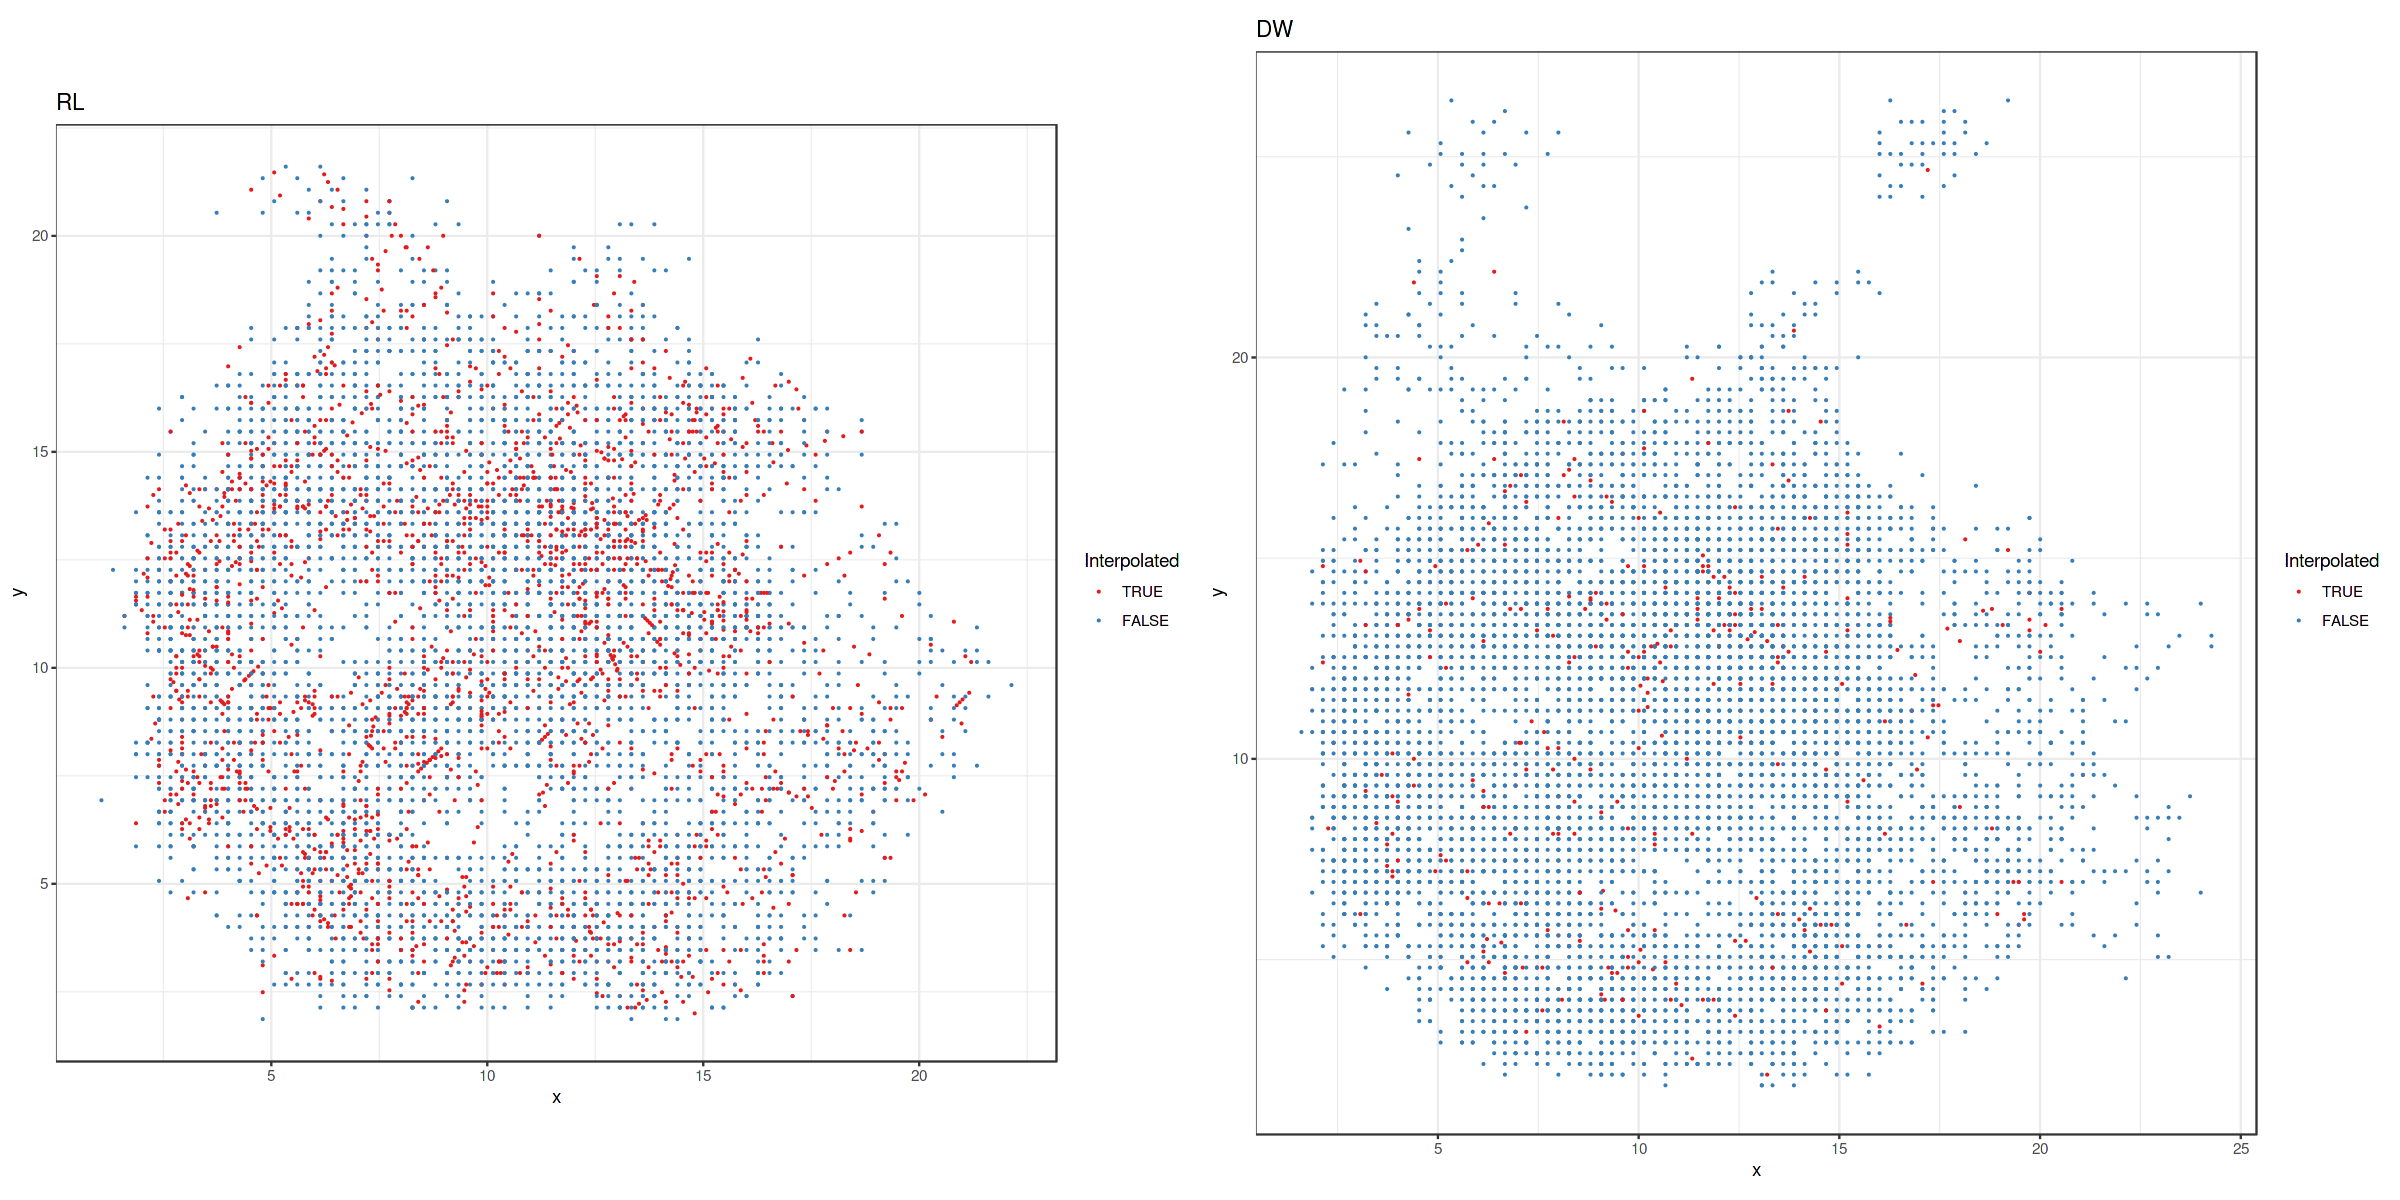

In [9]:
options(repr.plot.width=20, repr.plot.height=10)
p1 = ggplot(unique(coords_rl[, .(x, y, interpolated, file_id)]), aes(x, y, color=factor(interpolated, levels=c(TRUE, FALSE)))) +
    geom_point(size=.1) + coord_fixed() + theme_bw() + labs(title="RL") +
    scale_color_brewer(palette="Set1") + labs(color="Interpolated")
p2 = ggplot(unique(coords_dw[, .(x, y, interpolated, file_id)]), aes(x, y, color=factor(interpolated, levels=c(TRUE, FALSE)))) +
    geom_point(size=.1) + coord_fixed() + theme_bw() + labs(title="DW") +
    scale_color_brewer(palette="Set1") + labs(color="Interpolated")
plot_grid(p1, p2, nrow=1)

In [25]:
dim(coords_rl[, .(n_interp=sum(interpolated)), by=file_id][n_interp==0])

[1] 0 2

In [26]:
dim(coords_dw[, .(n_interp=sum(interpolated)), by=file_id][n_interp==0])

[1] 58  2

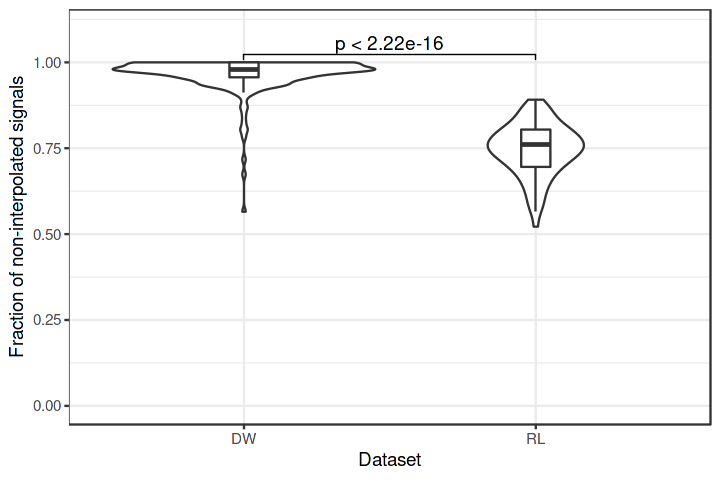

In [76]:
finterp_data = rbindlist(list(
    coords_rl[, .(finterp=sum(!interpolated)/46, method="RL"), by=file_id],
    coords_dw[, .(finterp=sum(!interpolated)/46, method="DW"), by=file_id]
))
options(repr.plot.width=6, repr.plot.height=4)
p = ggplot(finterp_data, aes(y=finterp, x=method)) +
    geom_violin() + geom_boxplot(width=.1, outlier.shape=NA) +
    theme_bw() + labs(x="Dataset", y="Fraction of non-interpolated signals") +
    stat_compare_means(comparisons=list(c(1,2)), method="wilcox.test") +
    scale_y_continuous(limits=c(0, 1.1), breaks=seq(0, 1, by=.25))
print(p)
save_and_plot(p, "plots/struct_count.interpol.violin", height=4, width=6, formats=c("jpg", "png", "pdf"))

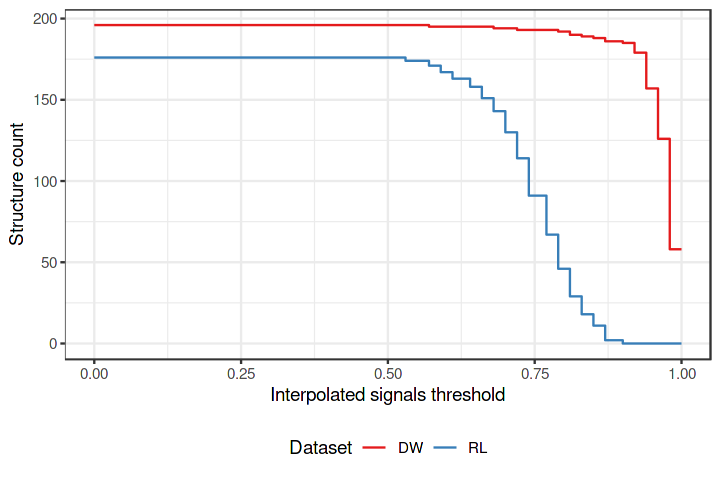

In [77]:
p = ggplot(finterp_data[, transpose(lapply(seq(0, 1, by=.01), function(x) {c(x, sum(finterp>=x))})), by=method]) +
    geom_step(aes(x=V1, y=V2, color=method)) + theme_bw() + scale_color_brewer(palette="Set1") +
    labs(x="Interpolated signals threshold", y="Structure count", color="Dataset") + theme(legend.position="bottom")
print(p)
save_and_plot(p, "plots/struct_count.interpol.cumsum", height=4, width=6, formats=c("jpg", "png", "pdf"))

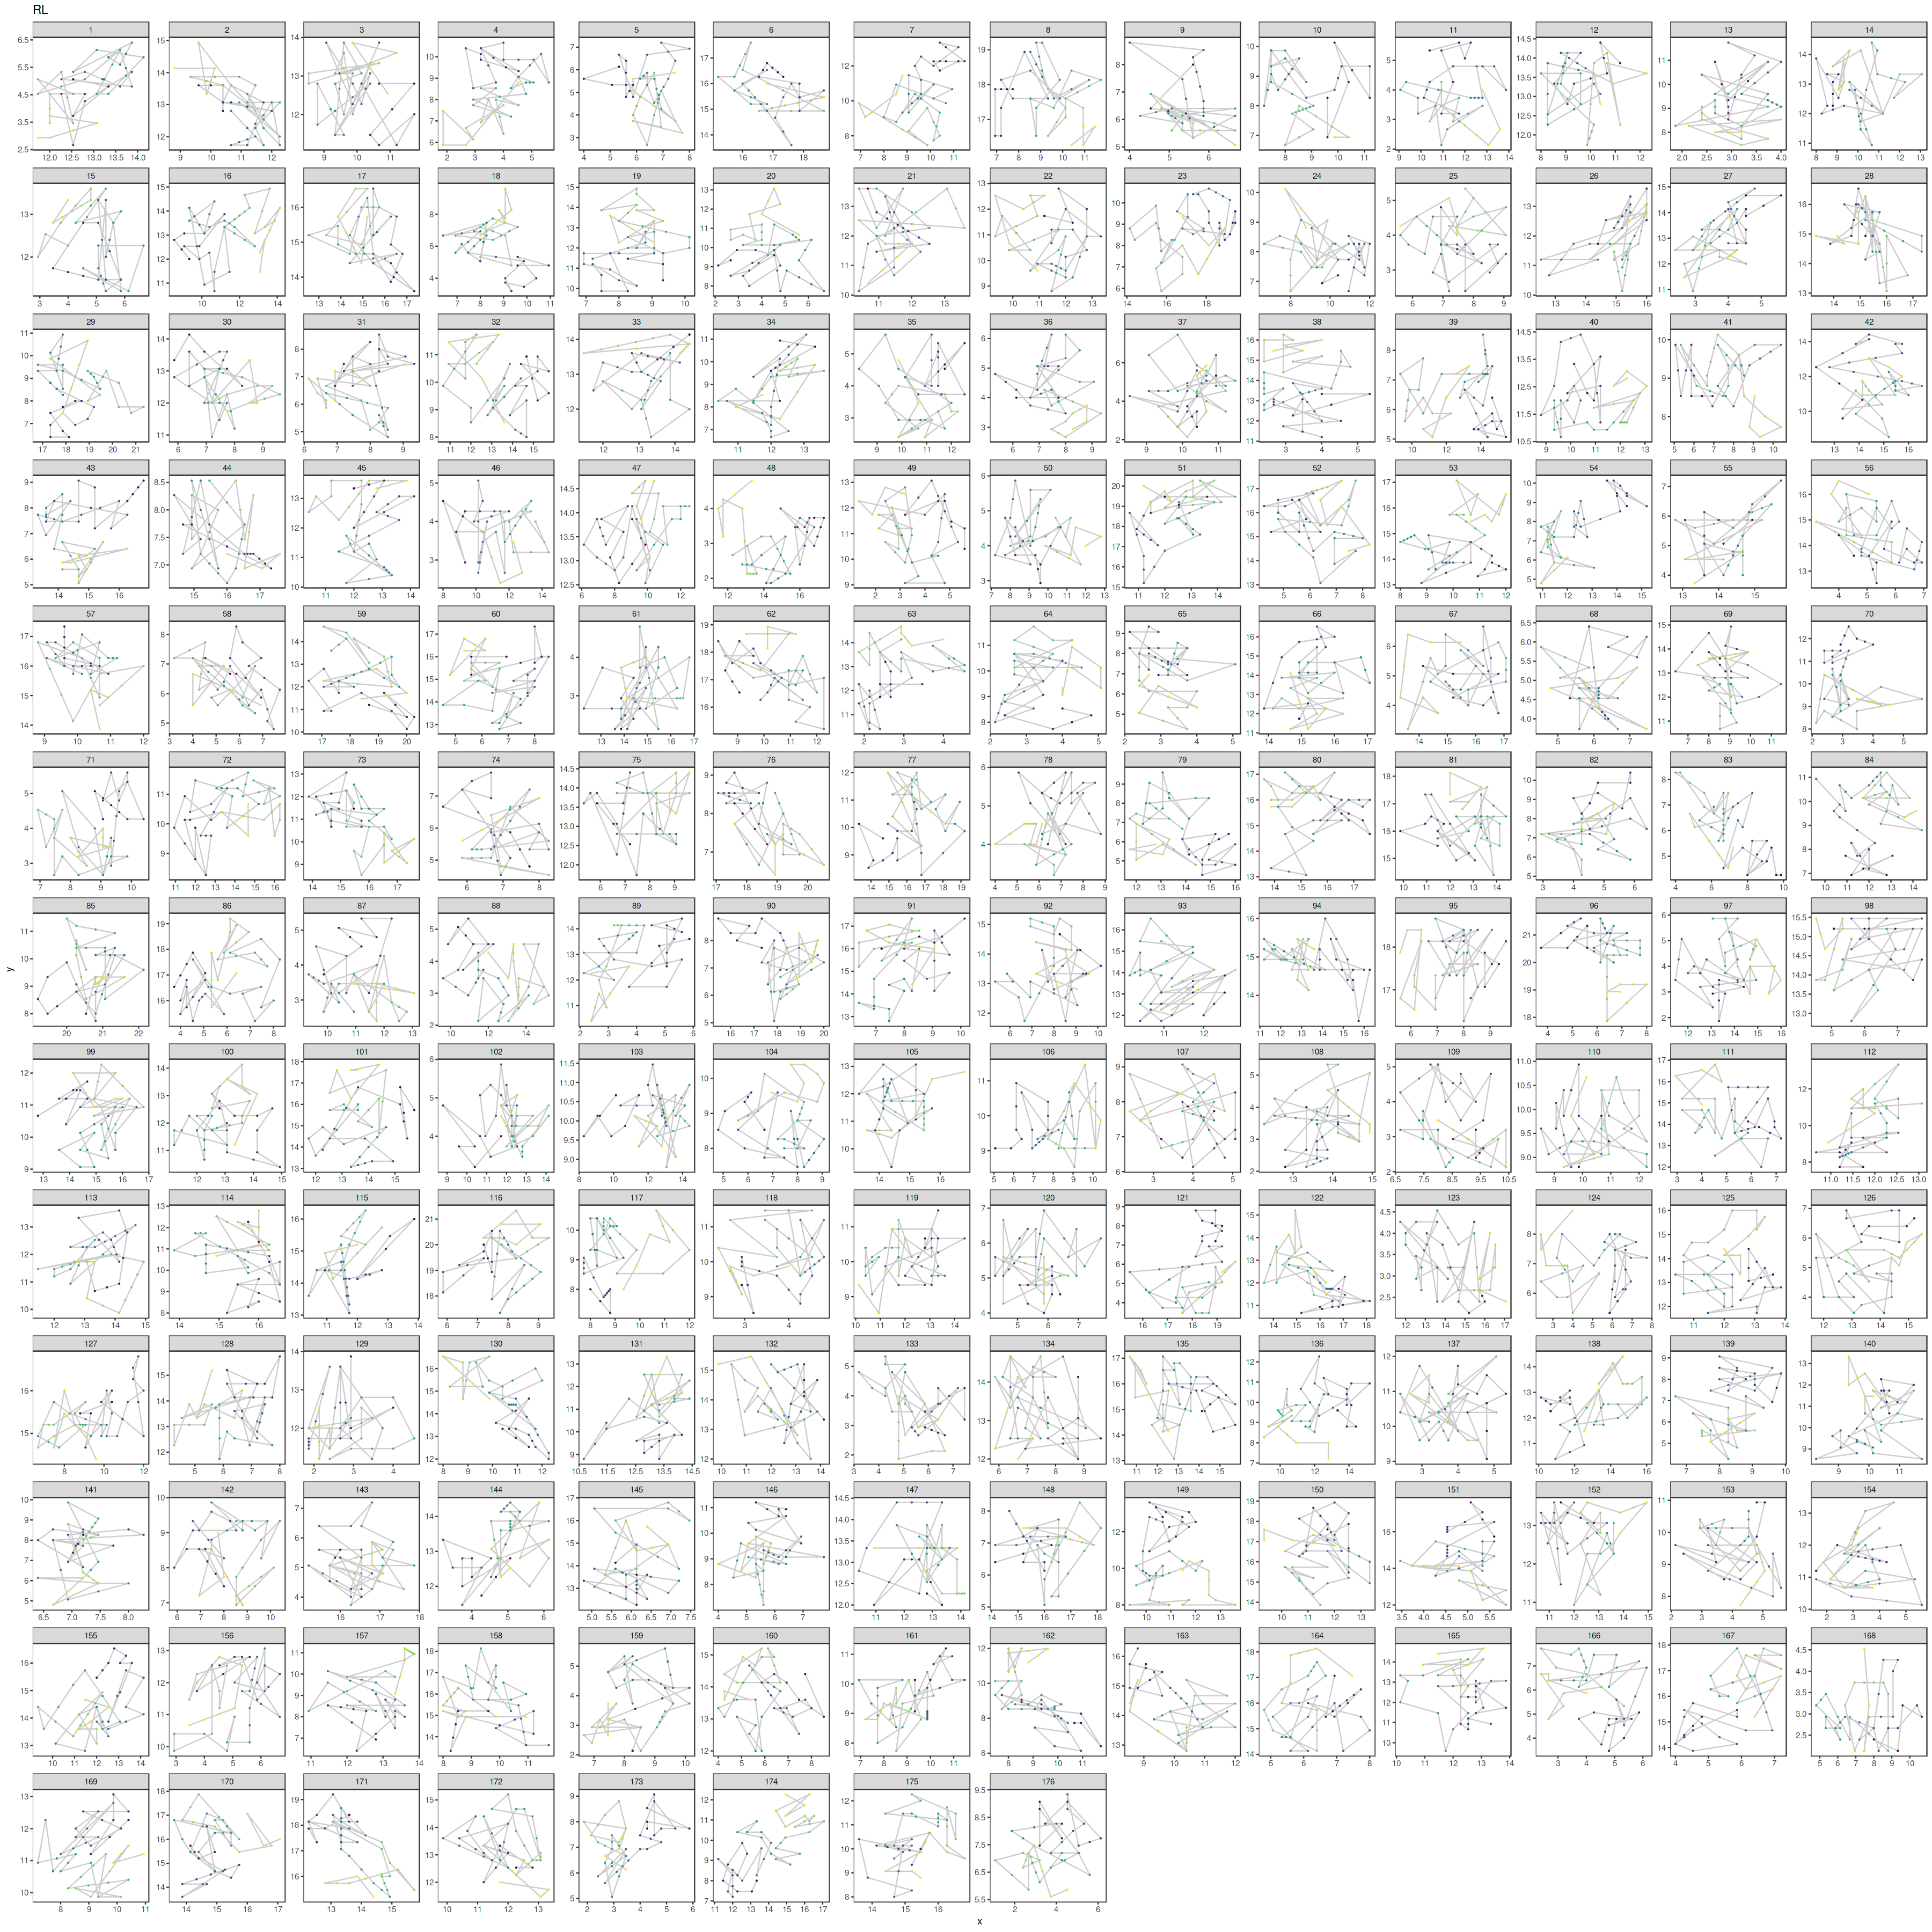

In [10]:
options(repr.plot.width=30, repr.plot.height=30)
ggplot(coords_rl[, .(i, x, y, file_id)], aes(x, y, color=i)) + geom_path(alpha=.2, color="black") + geom_point(size=.1) + 
    theme_bw() + facet_wrap(~file_id, scales="free") + guides(color="none") + scale_color_viridis() +
    theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) +
    labs(title="RL")

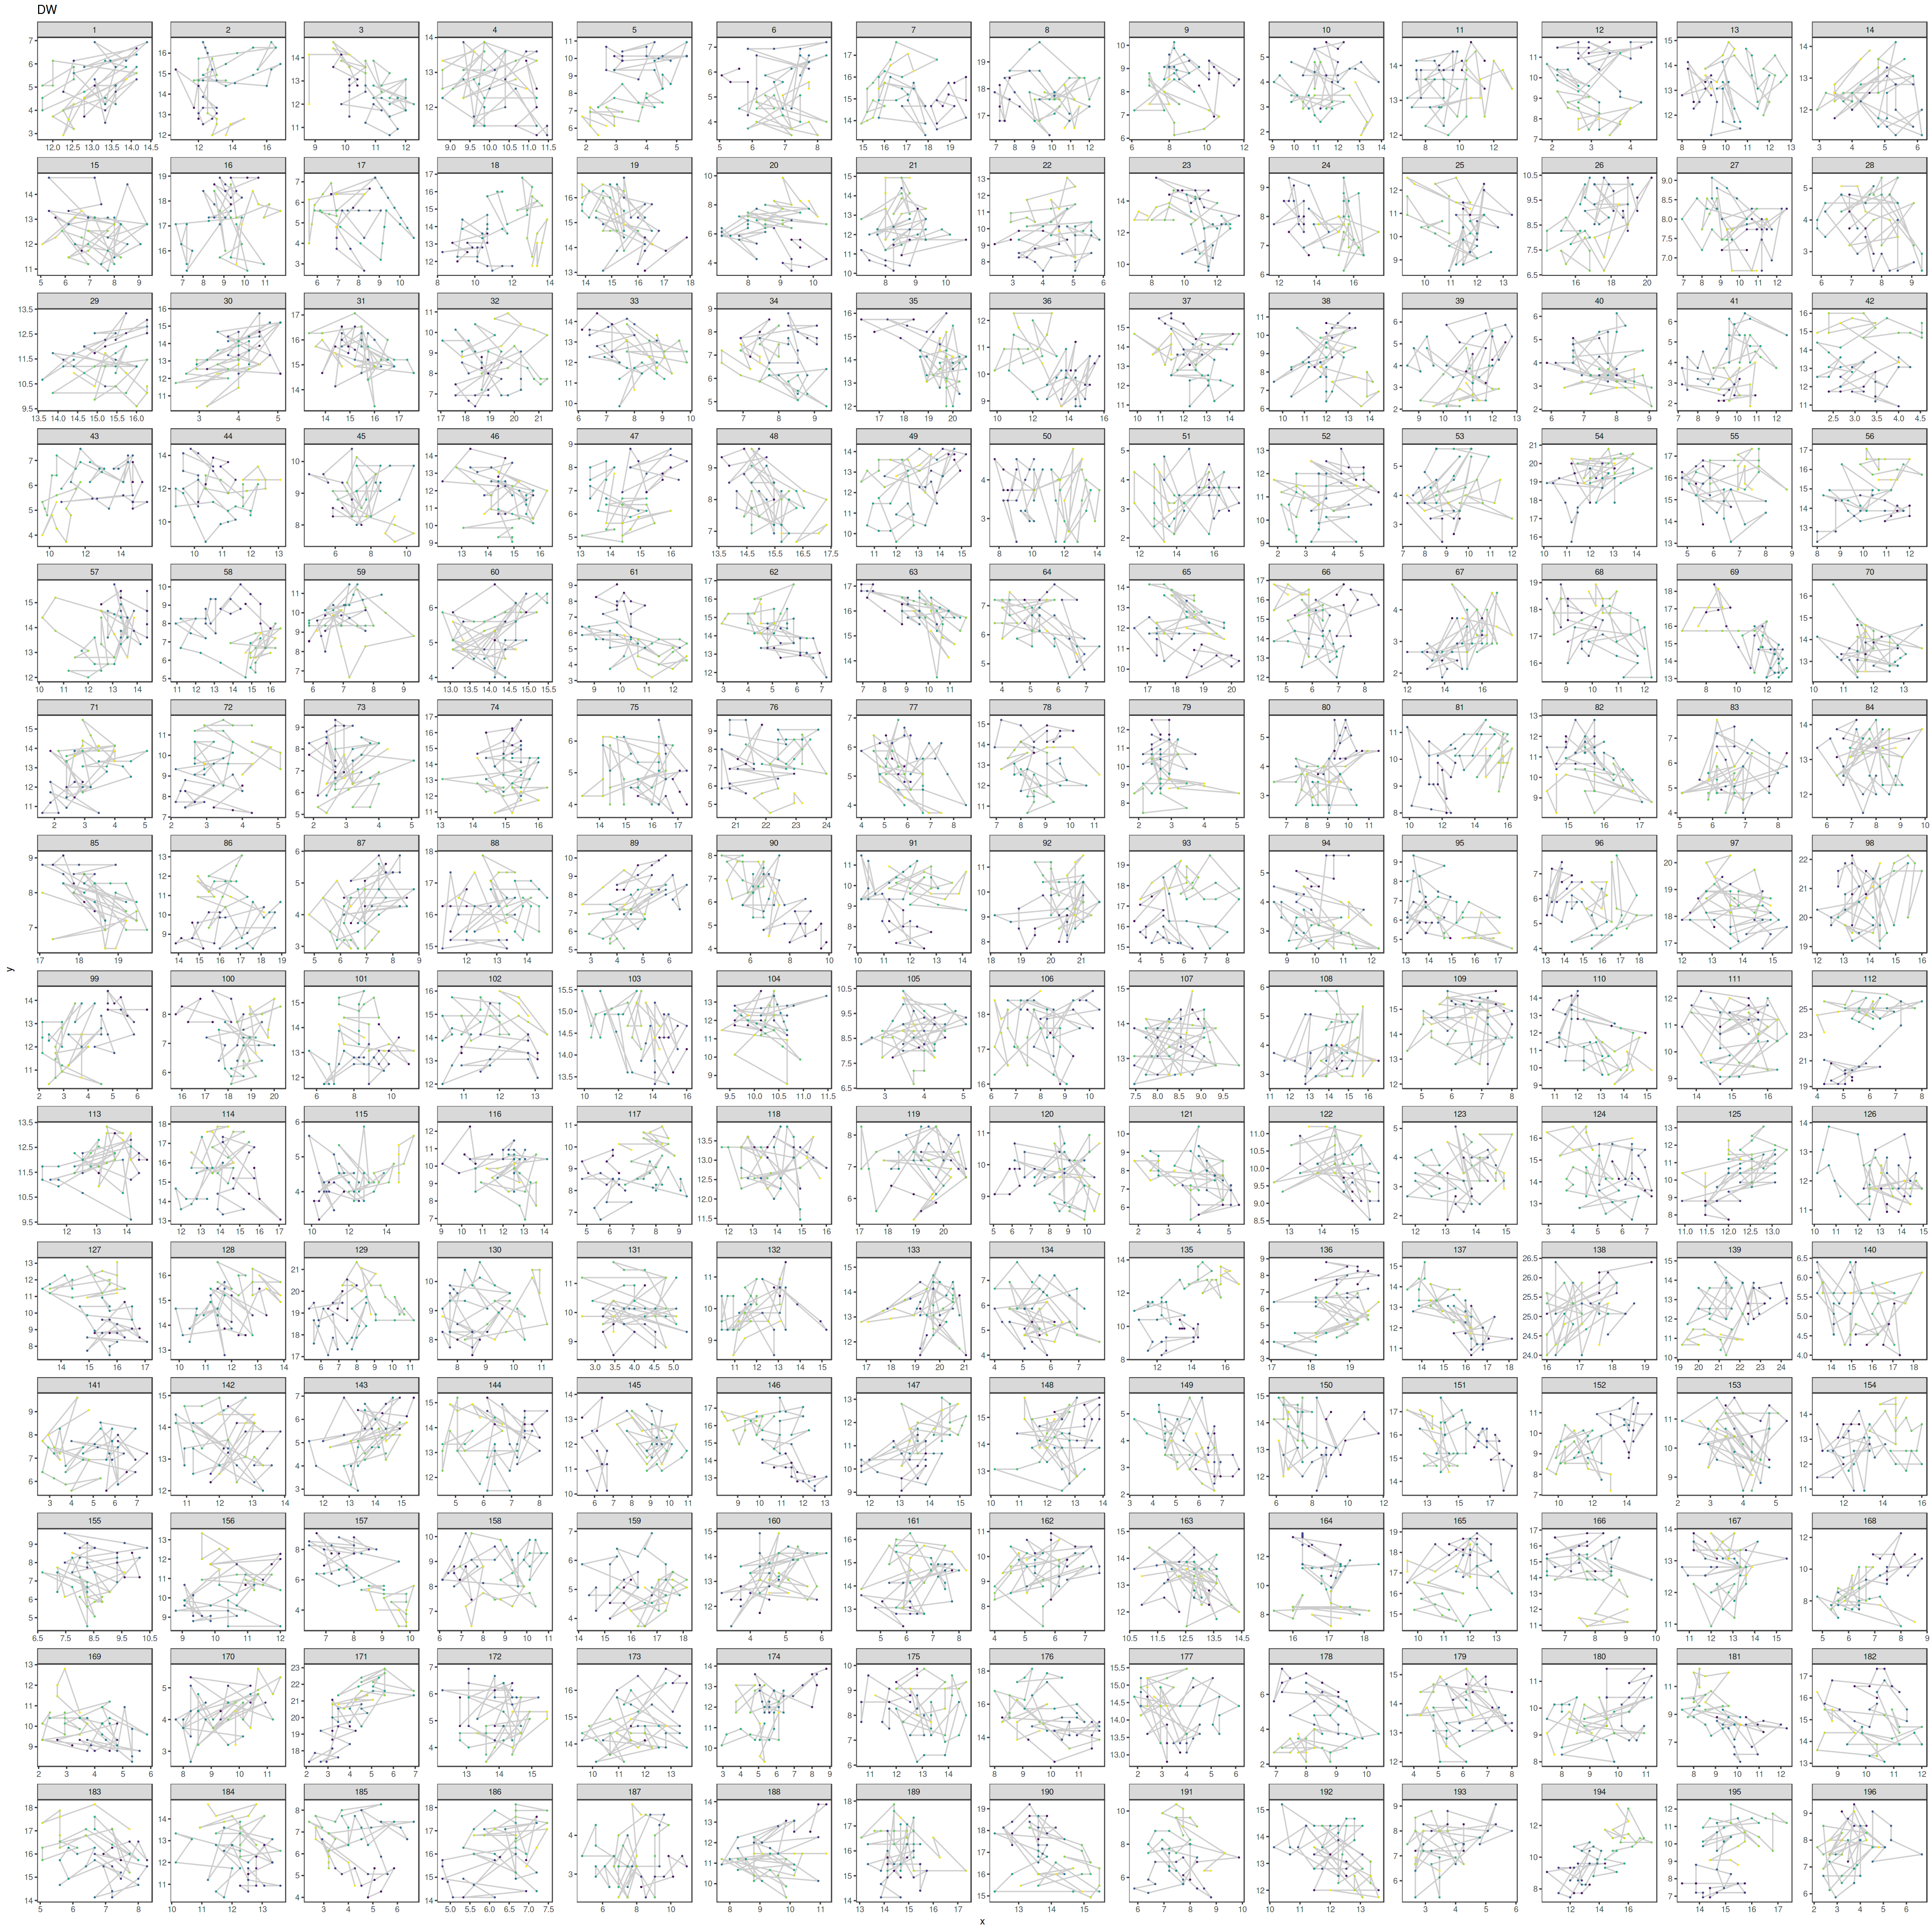

In [11]:
options(repr.plot.width=30, repr.plot.height=30)
ggplot(coords_dw[, .(i, x, y, file_id)], aes(x, y, color=i)) + geom_path(alpha=.2, color="black") + geom_point(size=.1) + 
    theme_bw() + facet_wrap(~file_id, scales="free") + guides(color="none") + scale_color_viridis() +
    theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) +
    labs(title="DW")

In [12]:
#options(repr.plot.width=12, repr.plot.height=6)
#p1 = ggplot(coords_rl[file_id==53, .(i, x, y, file_id)], aes(x, y, color=i)) + geom_path(alpha=.2, color="black") + geom_point(size=1) + 
#    theme_bw() + facet_wrap(~file_id, scales="free") + guides(color="none") + scale_color_viridis() +
#    theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) +
#    labs(title="RL")
#p2 = ggplot(coords_rl[file_id==59, .(i, x, y, file_id)], aes(x, y, color=i)) + geom_path(alpha=.2, color="black") + geom_point(size=1) + 
#    theme_bw() + facet_wrap(~file_id, scales="free") + guides(color="none") + scale_color_viridis() +
#    theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) +
#    labs(title="RL")
#plot_grid(p1, p2, nrow=1)